In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import FastText
from gensim.utils import simple_preprocess
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Embedding, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix


In [72]:
data=pd.read_csv('Reviews.csv')

In [73]:
print("shape: ",data.shape)

shape:  (568454, 10)


In [74]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [75]:
data=data[:50000]

In [76]:
data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               5
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64

In [77]:
data.dropna(inplace=True)

In [78]:
data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [79]:

data['Score'].value_counts()

Score
5    31127
4     7288
1     4720
3     4047
2     2811
Name: count, dtype: int64

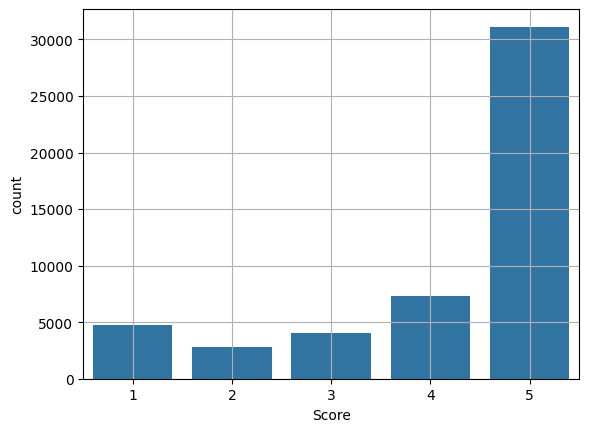

In [86]:
sns.countplot(x=data['Score'])
plt.grid()

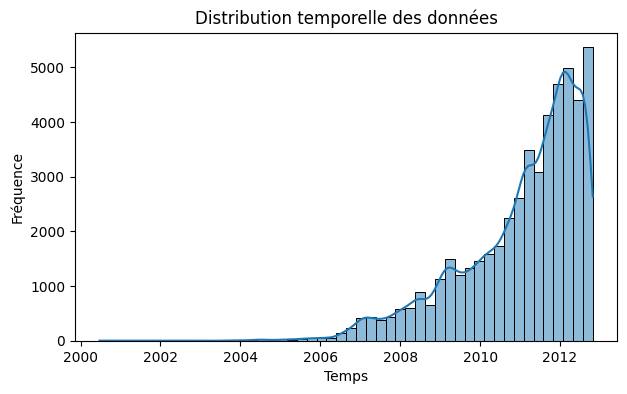

In [87]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')
plt.figure(figsize=(7, 4))
sns.histplot(data['Time'], bins=50, kde=True)
plt.title('Distribution temporelle des données')
plt.xlabel('Temps')
plt.ylabel('Fréquence')
plt.show()


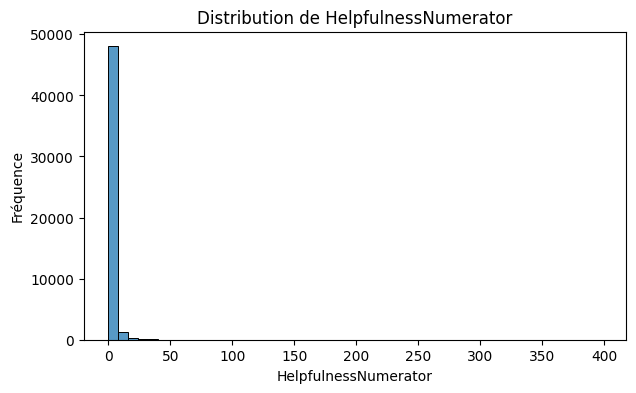

In [88]:

plt.figure(figsize=(7, 4))
sns.histplot(data['HelpfulnessNumerator'], bins=50)
plt.title('Distribution de HelpfulnessNumerator')
plt.xlabel('HelpfulnessNumerator')

plt.ylabel('Fréquence')
plt.show()
# la fréquence  montre combien d'avis ont un certain nombre de votes d'utilité

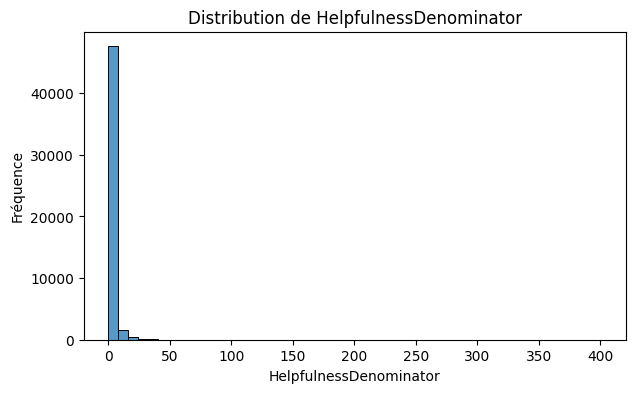

In [89]:
plt.figure(figsize=(7, 4))
sns.histplot(data['HelpfulnessDenominator'], bins=50)
plt.title('Distribution de HelpfulnessDenominator')
plt.xlabel('HelpfulnessDenominator')
plt.ylabel('Fréquence')
plt.show()

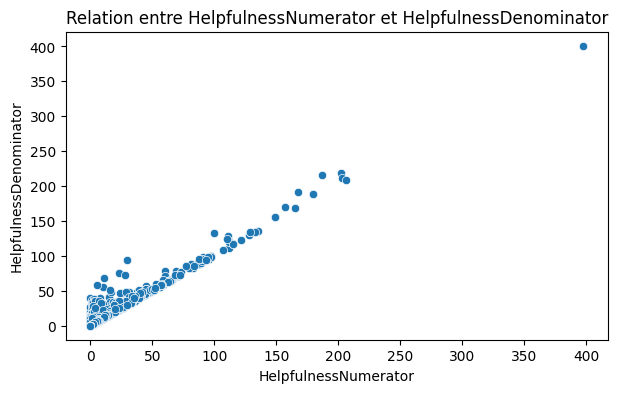

In [90]:
plt.figure(figsize=(7, 4))
sns.scatterplot(x='HelpfulnessNumerator', y='HelpfulnessDenominator', data=data)
plt.title('Relation entre HelpfulnessNumerator et HelpfulnessDenominator')
plt.xlabel('HelpfulnessNumerator')
plt.ylabel('HelpfulnessDenominator')
plt.show()

In [91]:

desired_samples_per_score = 6000
balanced_subsets = []

for score_value in range(1, 6):
    # Select data for the current score value
    data_score = data[data['Score'] == score_value]
    
    # Calculate the sample size based on the desired number of samples
    sample_size = min(desired_samples_per_score, len(data_score), len(data) // 5)
    
    # Sample data for the current score value
    data_score = data_score.sample(sample_size, random_state=42)
    
    # Add the sampled examples to the list
    balanced_subsets.append(data_score)

data_balanced = pd.concat(balanced_subsets, ignore_index=True)

data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [92]:
data_balanced['Score'].value_counts()

Score
5    6000
4    6000
1    4720
3    4047
2    2811
Name: count, dtype: int64

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


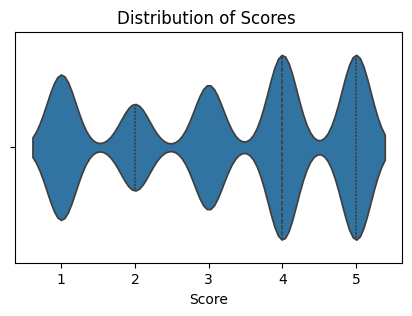

In [93]:
plt.figure(figsize=(5, 3))
sns.violinplot(x='Score', data=data_balanced, inner="quartile")
plt.title('Distribution of Scores ')
plt.show()

In [94]:
data_balanced['label'] = data_balanced['Score'].apply(lambda x: 1 if x > 3 else 0)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


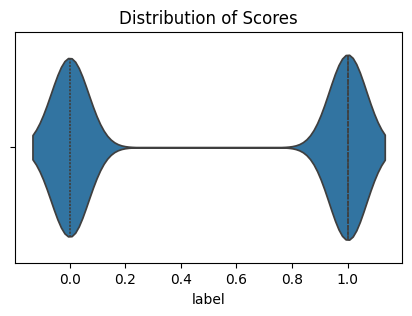

In [106]:

plt.figure(figsize=(5, 3))
sns.violinplot(x='label', data=data_balanced, inner="quartile")
plt.title('Distribution of Scores')
plt.show()

# data cleaning

In [96]:
patterns_to_find = [r':\)', r':\(', r':D']

# Find occurrences in each text
match_positions = {pattern: [match.start() for text in data_balanced['Text'] for match in re.finditer(pattern, text)] for pattern in patterns_to_find}

# Check and print the results for each pattern
for pattern, positions in match_positions.items():
    if positions:
        print(f"The pattern '{pattern}' is found at positions: {positions}")
    else:
        print(f"The pattern '{pattern}' is not found in any text.")


The pattern ':\)' is found at positions: [835, 88, 548, 1508, 628, 128, 89, 154, 228, 93, 129, 575, 369, 710, 459, 147, 404, 158, 421, 646, 604, 1165, 277, 435, 556, 204, 561, 499, 173, 309, 1036, 460, 411, 360, 1347, 517, 837, 473, 337, 347, 1245, 1415, 262, 460, 205, 81, 74, 720, 214, 647, 38, 773, 697, 767, 223, 228, 123, 126, 129, 583, 327, 325, 322, 1071, 1508, 453, 1277, 132, 312, 2228, 703, 187, 48, 371, 528, 2358, 1459, 1092, 368, 353, 384, 512, 901, 526, 205, 195, 1868, 543, 505, 198, 1685, 175, 79, 139, 193, 156, 221, 1205, 282, 1019, 20, 380, 807, 143, 394, 268, 27, 131, 283, 205, 373, 107, 807, 760, 83, 1806, 613, 612, 218, 844, 197, 1097, 460, 537, 238, 229, 179, 725, 113, 631, 674, 227, 544, 223, 101, 121, 15, 191, 117, 231, 239, 563, 335, 1193, 366, 451, 1208, 495, 611, 448, 444, 641, 559, 350, 3554, 291, 256, 681, 808, 94, 366, 582, 631, 583, 165, 507, 938, 547, 187, 53, 671, 663, 268, 534, 1093, 509, 717, 631, 1296, 477, 427, 638, 141, 312, 223, 547, 175, 203, 158, 509

In [97]:
data_balanced['Text'][2]

'This was gross. It lamb lund & smelled bad. There hard chips. My dogs Favorite is the Texas Taffy. Thats a winner. I cut it into peices. she LOVES THEM.'

In [98]:
patterns_to_remove = [r':\)', r':\(', r':D']

data_balanced = data_balanced.drop_duplicates()
def remove_patterns(text):
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text)
    return text


In [99]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'',text)

def remove_htmltags(text):
    html_pattern = re.compile(r'<.*?>')  
    return html_pattern.sub('', text)

def remove_extra_spaces_and_numbers(text):
    text = ' '.join(text.split())
    text = re.sub(r'\d+', '', text)
    return text



def remove_punctuations(text):
    translates = str.maketrans("", "", string.punctuation)
    return text.translate(translates)




In [26]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\user\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [27]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [100]:
def remove_stopwords(text):
    words = word_tokenize(text) # transfer the sentence into a list of words or tokens

    # Remove stopwords
    stop_words = set(stopwords.words('english')) #provides a set of common english stop words
    filtered_words = [word for word in words if word.lower() not in stop_words] #filters out the stop words from the list of words it cheks if each word in lower case , is not the set of stopwords

    cleaned_text = ' '.join(filtered_words)

    return cleaned_text


def lowercase(text):
    return text.lower()



In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

lemmatization to reduce the variety of the data 

In [101]:
#the difference between stemming and lematization is that a stemming chopping off the last letters but lemmatization uses a vocabulary for a meaningful sentence

def stem_text(text):
    stemmer = PorterStemmer()

    # Tokenize the text into words
    words = word_tokenize(text)

    # Stem each word
    stemmed_words = [stemmer.stem(word) for word in words]

    # Join the stemmed words back into a sentence
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text



# Apply all the preprocessing functions 

In [102]:
def clean_data(text):
    return lowercase(stem_text(remove_extra_spaces_and_numbers(remove_urls(remove_htmltags(remove_punctuations(remove_stopwords(remove_patterns(text))))))))


data_balanced['Text'] = data_balanced['Text'].apply(lambda text: clean_data(text))

In [103]:
data_balanced['Text'][2]

'gross lamb lund smell bad hard chip dog favorit texa taffi that winner cut peic love'

C:\Users\user\AppData\Local\Temp\ipykernel_16848\1993419018.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Count', data=df_word_counts.head(30), palette='viridis')
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_grou

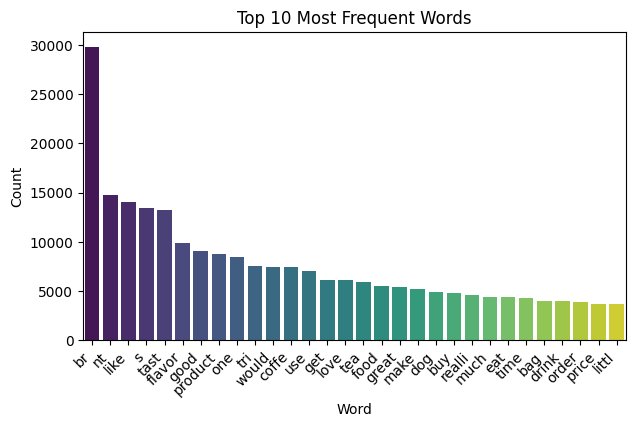

In [104]:
from collections import Counter
# Concatenate all the text in the specified column
text = ' '.join(data_balanced['Text'])

# Tokenize the text into words
words = text.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Convert the Counter to a DataFrame
df_word_counts = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count'])

# Sort the DataFrame by Count in descending order
df_word_counts = df_word_counts.sort_values(by='Count', ascending=False)


plt.figure(figsize=(7, 4))
sns.barplot(x='Word', y='Count', data=df_word_counts.head(30), palette='viridis')
plt.title('Top 10 Most Frequent Words')
plt.xticks(rotation=45, ha='right')
plt.show()


# Text vectorization Fast Text Model

In [34]:
pip install fasttext

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Running setup.py clean for fasttext
Failed to build fasttext
    Running setup.py install for fasttext: started
    Running setup.py install for fasttext: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'c:\Users\user\AppData\Local\Programs\Python\Python310\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\user\\AppData\\Local\\Temp\\pip-install-c20wz9ad\\fasttext_2a19473ed4054e4e8036605378f14453\\setup.py'"'"'; __file__='"'"'C:\\Users\\user\\AppData\\Local\\Temp\\pip-install-c20wz9ad\\fasttext_2a19473ed4054e4e8036605378f14453\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\user\AppData\Local\Temp\pip-wheel-zgmaatu3'
       cwd: C:\Users\user\AppData\Local\Temp\pip-install-c20wz9ad\fasttext_2a19473ed4054e4e8036605378f14453\
  Complete output (62 lines):
  c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\setuptools\d

In [35]:
pip install gensim 

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\user\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [105]:

text_data = data_balanced['Text'].tolist()
target_data = data_balanced['label'].tolist()


tokenized_data = [simple_preprocess(text) for text in text_data]

model = FastText(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4, sg=1)

# Initialize an empty list to store the embeddings
embedding_data = []

# Loop through each text in the original data
for text in text_data:

    tokens = simple_preprocess(text)
    
    # Get word vectors for each token and filter out tokens not in the vocabulary
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    
    # If there are vectors, compute the mean vector and append to the list
    if vectors:
        mean_vector = sum(vectors) / len(vectors)
        embedding_data.append(mean_vector)
    else:
        # If no vectors found (all tokens out of vocabulary), append a zero vector
        embedding_data.append([0.0] * model.vector_size)

embedding_data = np.array(embedding_data)


## Split the data

In [107]:
X_train, X_test, y_train, y_test = train_test_split(embedding_data, target_data, test_size=0.2, random_state=42)

# building the logistic regression model

In [108]:
model_2 = LogisticRegression()
model_2.fit(X_train, y_train)

LogisticRegression()

In [109]:

y_pred = model_2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_result)

Accuracy: 0.777565733672604
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2274
           1       0.79      0.77      0.78      2442

    accuracy                           0.78      4716
   macro avg       0.78      0.78      0.78      4716
weighted avg       0.78      0.78      0.78      4716



# CNN model

In [40]:
#if your labels are binary (0 or 1), you should use binary cross-entropy as the loss function, not sparse categorical cross-entropy.

In [110]:

y_train = np.array(y_train)
y_test = np.array(y_test)


model_1 = Sequential()
model_1.add(Conv1D(128, 5, activation='relu', input_shape=(100, 1)))
model_1.add(GlobalMaxPooling1D())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))  #  'sigmoid' for binary classification and' to produce probability scores between 0 and 1.


model_1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Reshape X_train and X_test to match the input shape of the model
X_train1 = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test1 = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


model_1.fit(X_train1, y_train, epochs=35, batch_size=32, validation_data=(X_test1, y_test))


loss, accuracy = model_1.evaluate(X_test1, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/35
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5142 - loss: 0.6923 - val_accuracy: 0.6692 - val_loss: 0.6785
Epoch 2/35
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5849 - loss: 0.6747 - val_accuracy: 0.6924 - val_loss: 0.6252
Epoch 3/35
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6542 - loss: 0.6340 - val_accuracy: 0.7086 - val_loss: 0.5821
Epoch 4/35
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6731 - loss: 0.6049 - val_accuracy: 0.7154 - val_loss: 0.5670
Epoch 5/35
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6850 - loss: 0.5963 - val_accuracy: 0.6810 - val_loss: 0.5911
Epoch 6/35
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6867 - loss: 0.5881 - val_accuracy: 0.7118 - val_loss: 0.5689
Epoch 7/35
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6946 - loss: 0.5801 - val_accuracy: 0.6981 - val_loss: 0.5650
Epoch 8/35
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6931 - loss: 0.5858 - val_accuracy

In [115]:
from sklearn.metrics import classification_report

y_pred_prob = model_1.predict(X_test1)
#y_pred_classes = (y_pred_prob > 0.5).astype(int)   Convert probabilities to binary classes (0 or 1)
y_pred_classes = (y_pred_prob > 0.5).astype(int).ravel()

classification_report_result = classification_report(y_test, y_pred_classes)

print("Classification Report:")
print(classification_report_result)


148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.63      0.69      2274
           1       0.71      0.82      0.76      2442

    accuracy                           0.73      4716
   macro avg       0.74      0.73      0.73      4716
weighted avg       0.74      0.73      0.73      4716



In [116]:
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred_classes:", y_pred_classes.shape)


Shape of y_test: (4716,)
Shape of y_pred_classes: (4716,)


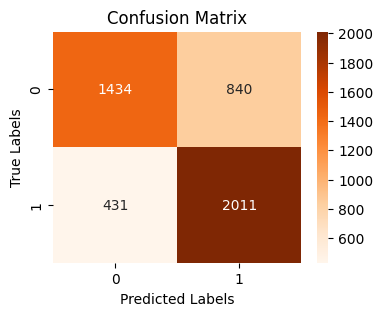

In [117]:

conf_matrix = confusion_matrix(y_test, y_pred_classes)


plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [118]:
from keras.models import load_model

model_1.save("model_1.h5")


def load_model():
    model = load_model("model_1.h5")
   
    return model

# test the model 

In [122]:

example_text = "noo doesnt tast good eww"

cleaned_example = clean_data(example_text)
print("Original Text:", example_text)
print("Cleaned Text:", cleaned_example)


tokenized_example = simple_preprocess(example_text)

example_embedding = []

# Loop through each token in the tokenized example
for token in tokenized_example:
    # Get the word vector for each token from the trained FastText model
    vector = model.wv[token] if token in model.wv else [0.0] * model.vector_size
    
    # Append the vector to the list
    example_embedding.append(vector)

# If there are vectors, compute the mean vector for the example
if example_embedding:
    mean_example_vector = np.mean(example_embedding, axis=0)
else:
    # If no vectors found (all tokens out of vocabulary), use a zero vector
    mean_example_vector = [0.0] * model.vector_size

# Convert the mean example vector to a NumPy array
example_data = np.array(mean_example_vector)

# Reshape the example data if needed
example_data = example_data.reshape((1, example_data.shape[0], 1))


predicted_prob = model_1.predict(example_data)
predicted_class = (predicted_prob > 0.5).astype(int)


if predicted_class[0][0] == 1:
    print("The model predicts: Positive")
else:
    print("The model predicts: Negative")


Original Text: noo doesnt tast good eww
Cleaned Text: noo doesnt tast good eww
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
The model predicts: Negative
